In [65]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import networkx as nx
from node2vec import Node2Vec

df = pd.read_csv('bank.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [66]:
df.job.unique()

array(['unemployed', 'services', 'management', 'blue-collar',
       'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
       'housemaid', 'retired', 'unknown'], dtype=object)

In [67]:
df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(0 if x == 'student' else( 0 if x == 'housemaid' else(0 if x == 'unknown' else(0 if x == 'blue-collar' else(0 if x == 'retired' else(0 if x == 'technician' else 1)))))))

df.marital = df.marital.apply(lambda x: 0 if x == 'single' else 1)
df.education = df.education.apply(lambda x: 1 if x == 'tertiary' else 0)
df.default = df.default.apply(lambda x: 0 if x == 'no' else 1)
df.housing = df.housing.apply(lambda x: 0 if x == 'no' else 1)
df.loan = df.loan.apply(lambda x: 0 if x == 'no' else 1)
df.contact = df.contact.apply(lambda x: 1 if x == 'cellular' else 0)
df.poutcome = df.poutcome.apply(lambda x: 1 if x == 'success' else 0)
df.y = df.y.apply(lambda x: 1 if x == 'yes' else 0)

In [68]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,0,1,0,0,1787,0,0,1,19,oct,79,1,-1,0,0,0
1,33,1,1,0,0,4789,1,1,1,11,may,220,1,339,4,0,0
2,35,1,0,1,0,1350,1,0,1,16,apr,185,1,330,1,0,0
3,30,1,1,1,0,1476,1,1,0,3,jun,199,4,-1,0,0,0
4,59,0,1,0,0,0,1,0,0,5,may,226,1,-1,0,0,0


In [69]:
X = df[['job','marital','default','housing','loan','contact','poutcome','y']]
X.head()

,job,marital,default,housing,loan,contact,poutcome,y
0,0,1,0,0,0,1,0,0
1,1,1,0,1,1,1,0,0
2,1,0,0,1,0,1,0,0
3,1,1,0,1,1,0,0,0
4,0,1,0,1,0,0,0,0


In [70]:
Y = X['y']
#Y = Y.loc[0:5000]
x = X[['job','marital','default','housing','loan','contact','poutcome']]
#x = x.loc[0:5000,:]
Y = Y.to_numpy()
x = x.to_numpy()
x = x.T

In [71]:
alpha = 0.98
beta = 0.58
gamma = 0.05
aff = np.array([[alpha,beta],[beta, gamma]])

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            prob_u_v[j] = aff[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 



np.fill_diagonal(P_u_v,0)
np.triu(P_u_v)


array([[0.00000000e+00, 4.68463912e-04, 9.18189268e-03, ...,
        2.25980199e-03, 2.25980199e-03, 5.43418138e-03],
       [0.00000000e+00, 0.00000000e+00, 4.03848200e-05, ...,
        4.68463912e-04, 4.68463912e-04, 3.48145000e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.18189268e-03, 9.18189268e-03, 6.82364200e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.25980199e-03, 5.43418138e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.43418138e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [72]:
A = np.triu(P_u_v,0)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0



In [73]:
A = A + A.T - np.diag(np.diag(A))
np.sum(A) / 2

263020.0

In [74]:
G = nx.from_numpy_matrix(A)

In [9]:
node2vec = Node2Vec(G, dimensions=6, walk_length=30, num_walks=200, workers=2)

Computing transition probabilities: 100%|██████████| 3993/3993 [20:13<00:00,  3.29it/s]


In [10]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [11]:
model.wv.save_word2vec_format('embeddings')

In [14]:
t = pd.read_csv('embeddings', delimiter = " ", index_col=0)
t.sort_index(inplace=True)
t.columns = ['x1','x2','x3','x4']
t = t.to_numpy()
t.shape

(3993, 4)

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(t,Y, test_size = 0.2, shuffle=True)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(12, input_dim=4, activation='relu', name='layer1'))
model.add(Dense(8, activation='relu', name='layer2'))
model.add(Dense(1, activation='sigmoid', name='layer3'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf, validation_data=(x_test_tf,y_test_tf), epochs=10, batch_size=10)

Epoch 1/10
320/320 [==============================] - 2s 3ms/step - loss: 0.7854 - accuracy: 0.6711 - val_loss: 0.3364 - val_accuracy: 0.8949
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 0.3569 - accuracy: 0.8815 - val_loss: 0.3301 - val_accuracy: 0.8949
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 0.3485 - accuracy: 0.8826 - val_loss: 0.3306 - val_accuracy: 0.8949
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 0.3436 - accuracy: 0.8829 - val_loss: 0.3269 - val_accuracy: 0.8949
Epoch 5/10
320/320 [==============================] - 1s 3ms/step - loss: 0.3414 - accuracy: 0.8838 - val_loss: 0.3253 - val_accuracy: 0.8949
Epoch 6/10
320/320 [==============================] - 1s 3ms/step - loss: 0.3426 - accuracy: 0.8874 - val_loss: 0.3275 - val_accuracy: 0.8949
Epoch 7/10
320/320 [==============================] - 1s 3ms/step - loss: 0.3305 - accuracy: 0.8927 - val_loss: 0.3246 - val_accuracy: 0.8949
Epoch 

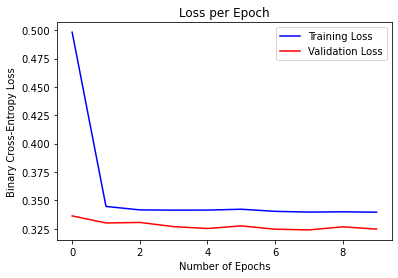

In [18]:
plt.plot(history.history['loss'],label = 'Training Loss', color = 'blue')
plt.plot(history.history['val_loss'],label = 'Validation Loss', color = 'red')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

In [76]:
model.layers[2].output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'layer3')>

In [77]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 12)                36        
_________________________________________________________________
layer2 (Dense)               (None, 8)                 104       
_________________________________________________________________
layer3 (Dense)               (None, 1)                 9         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [13]:
np.sum(y_train) / len(y_train)

0.1123982467125861

In [14]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(x_train,y_train)
clf.score(x_train,y_train)

0.8876017532874139

In [15]:
import statsmodels.api as sm

log_reg = sm.Logit(y_train, x_train).fit()
print(log_reg.summary())


Optimization terminated successfully.
         Current function value: 0.337010
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3194
Model:                          Logit   Df Residuals:                     3192
Method:                           MLE   Df Model:                            1
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                 0.04123
Time:                        13:29:21   Log-Likelihood:                -1076.4
converged:                       True   LL-Null:                       -1122.7
Covariance Type:            nonrobust   LLR p-value:                 6.509e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8393      0.024     34.860      0.000       0.792       0.886
x2             5.9817      0.

In [16]:
from sklearn.model_selection import train_test_split
x
x_train, x_test, y_train, y_test = train_test_split(x.T,Y, test_size = 0.4, shuffle=True)

In [17]:
log_reg = sm.Logit(y_train, x_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.346553
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2395
Model:                          Logit   Df Residuals:                     2389
Method:                           MLE   Df Model:                            5
Date:                Sun, 25 Apr 2021   Pseudo R-squ.:                0.006258
Time:                        13:29:43   Log-Likelihood:                -830.00
converged:                       True   LL-Null:                       -835.22
Covariance Type:            nonrobust   LLR p-value:                   0.06336
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2053      0.111    -10.859      0.000      -1.423      -0.988
x2            -0.1546      0.

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(12, input_dim=6, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf, validation_data=(x_test_tf,y_test_tf), epochs=10, batch_size=10)

Epoch 1/10
240/240 [==============================] - 1s 4ms/step - loss: 0.4672 - accuracy: 0.8842 - val_loss: 0.3480 - val_accuracy: 0.8886
Epoch 2/10
240/240 [==============================] - 0s 2ms/step - loss: 0.3699 - accuracy: 0.8753 - val_loss: 0.3383 - val_accuracy: 0.8886
Epoch 3/10
240/240 [==============================] - 0s 2ms/step - loss: 0.3215 - accuracy: 0.8913 - val_loss: 0.3230 - val_accuracy: 0.8886
Epoch 4/10
240/240 [==============================] - 1s 2ms/step - loss: 0.3194 - accuracy: 0.8869 - val_loss: 0.3186 - val_accuracy: 0.8955
Epoch 5/10
240/240 [==============================] - 1s 2ms/step - loss: 0.3400 - accuracy: 0.8914 - val_loss: 0.3169 - val_accuracy: 0.8955
Epoch 6/10
240/240 [==============================] - 0s 2ms/step - loss: 0.3139 - accuracy: 0.8970 - val_loss: 0.3156 - val_accuracy: 0.8955
Epoch 7/10
240/240 [==============================] - 1s 2ms/step - loss: 0.3068 - accuracy: 0.9045 - val_loss: 0.3152 - val_accuracy: 0.8942
Epoch 